<a href="https://colab.research.google.com/github/gadm21/satellite-imagery-analysis/blob/main/%22urban%20development%20map%22/change_detection_in_dubai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [102]:
import cv2 
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import skimage.morphology
import numpy as np
import time

from google.colab.patches import cv2_imshow

#Functions

In [103]:
def get_vec_set(diff_image):

    img_size = diff_image.shape[0]
    i = 0
    j = 0
    vector_set = np.zeros((int(img_size * img_size / 25),25))
    while i < vector_set.shape[0]:
        while j < img_size:
            k = 0
            while k < img_size:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
 
    mean_vec   = np.mean(vector_set, axis = 0)
    # Mean normalization
    vector_set = vector_set - mean_vec   
    return vector_set, mean_vec

def find_FVS(EVS, diff_image, mean_vec):
 
    i = 2
    feature_vector_set = []
    img_size = diff_image.shape[0]
 
    while i < img_size - 2:
        j = 2
        while j < img_size - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1

    print("feature vector set: {} {}  EVS: {}".format(len(feature_vector_set), feature_vector_set[0].shape, EVS.shape))
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    
    return FVS

def clustering(FVS, components, shape):
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)
 
    least_index = min(count, key = count.get)
    change_map  = np.reshape(output,(shape[1] - 4, shape[0] - 4))
    return least_index, change_map

def show_both(image1, image2):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 13))
  axes[0].imshow(image1, cmap='gray')
  axes[0].title.set_text( 'dubai at 2000')
  axes[1].imshow(image2, cmap='gray')
  axes[1].title.set_text('dubai at 2012')


def show_image(image, title = None, cmap=None):
  plt.figure(figsize=(15, 13))
  if cmap : plt.imshow(image, cmap = cmap) 
  else : plt.imshow(image)

  if title : plt.title(label = title)

#Play

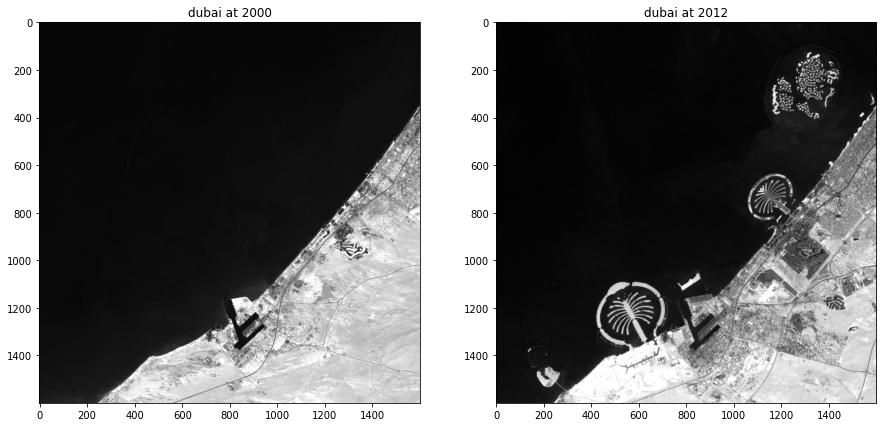

In [104]:
dubai_2000 = cv2.imread('Dubai_2000_gray.jpg', cv2.IMREAD_GRAYSCALE)
dubai_2012 = cv2.imread('Dubai_2012_gray.jpg', cv2.IMREAD_GRAYSCALE)
show_both(dubai_2000, dubai_2012)


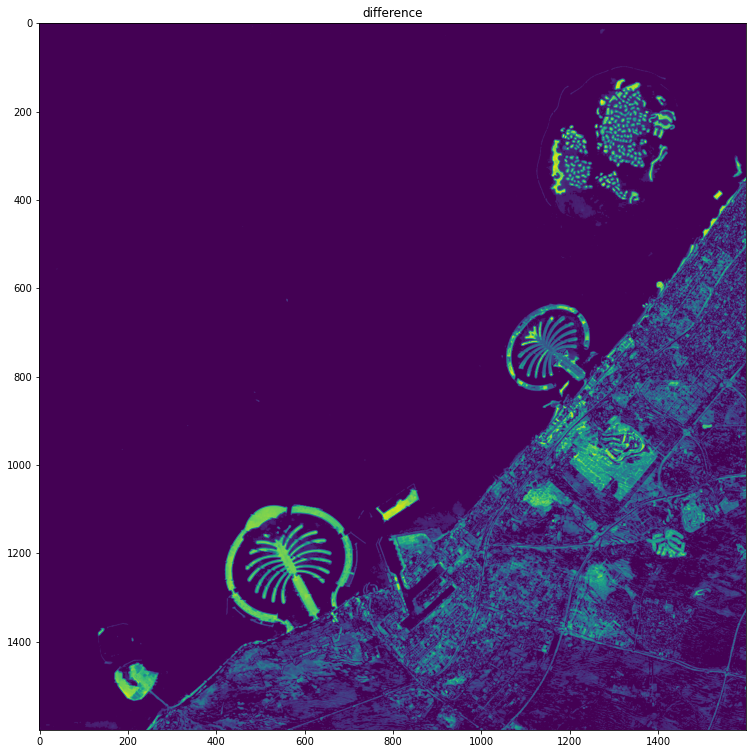

In [105]:
diff = abs(dubai_2012.copy().astype(int)  - dubai_2000)
diff[(diff < 0.5*diff.std())] = 0
show_image(diff, 'difference')

In [106]:
vector_set, mean_vector = get_vec_set(diff)
vector_set.shape, mean_vector.shape

((102400, 25), (25,))

In [107]:
pca = PCA() 
pca.fit(vector_set) 
evs = pca.components_
evs.shape

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


(25, 25)

In [108]:
fvs = find_FVS(evs, diff, mean_vector) 
print("fvs:", fvs.shape)

feature vector set: 2547216 (25,)  EVS: (25, 25)
fvs: (2547216, 25)


In [109]:
least_index, change_map = clustering(fvs, 3, diff.shape)

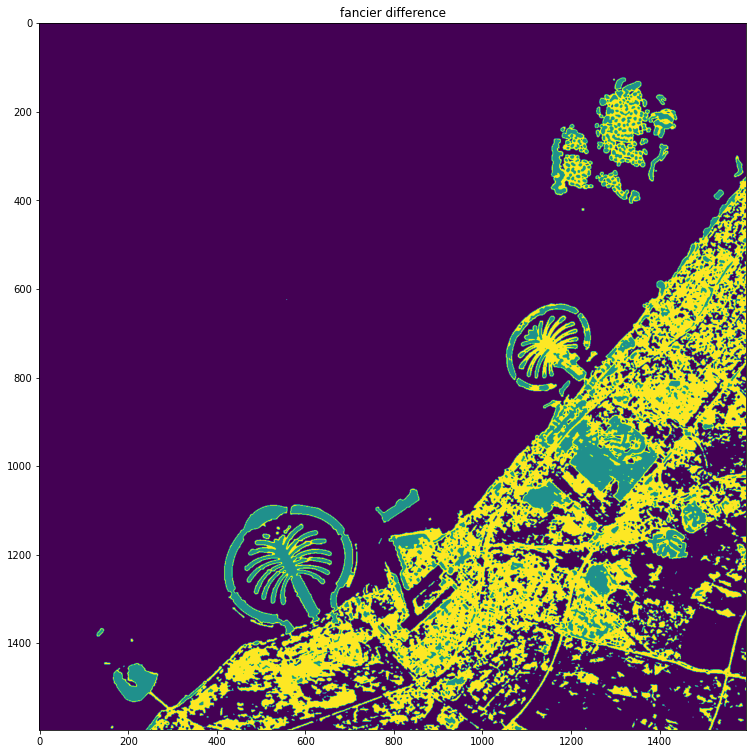

In [110]:
show_image(change_map, 'fancier difference')

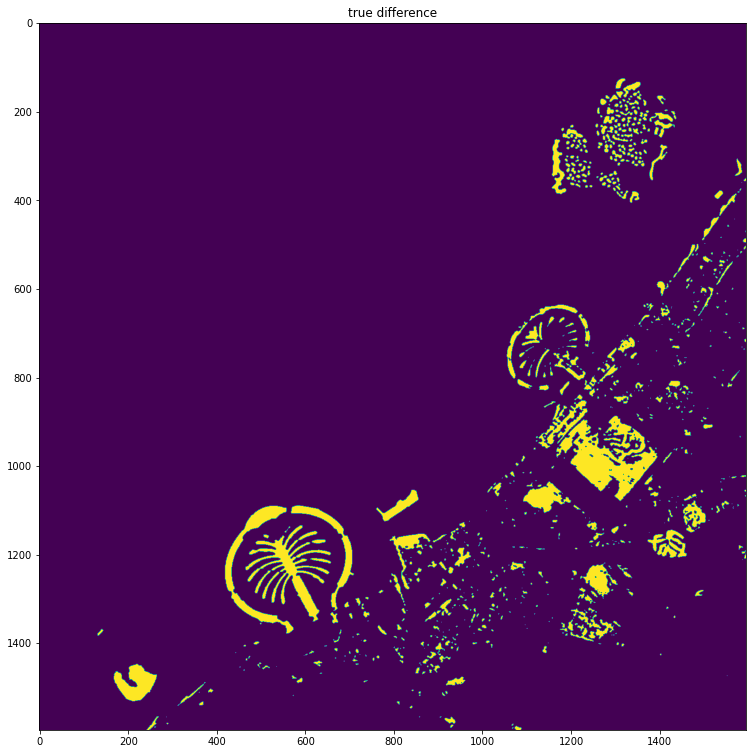

In [111]:
change_map[change_map==least_index] = 255 
change_map[change_map!=255] = 0 
show_image(change_map, 'true difference')